# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower, TTestPower
import statsmodels.api as sm
from statsmodels.formula.api import ols

from flatiron_stats import *

%matplotlib inline

In [2]:
home_act = pd.read_csv('homepage_actions.csv')
home_act.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [3]:
home_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


In [4]:
home_act.action.unique()

array(['view', 'click'], dtype=object)

In [5]:
len(home_act.id.unique())

6328

## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [6]:
act_dict = {'view': 0, 'click': 1}

In [7]:
home_act.action = home_act.action.map(lambda x: act_dict[x])

In [8]:
control = home_act.loc[home_act.group == 'control']
experimental = home_act.loc[home_act.group == 'experiment']

In [9]:
control_view = control.loc[control.action == 0]
experimental_view = experimental.loc[experimental.action == 0]

control_click = control.loc[control.action == 1]
experimental_click = experimental.loc[experimental.action == 1]

In [10]:
control_view.id = control_view.id.map(lambda x: x if x not in list(control_click.id) else None)
experimental_view.id = \
experimental_view.id.map(lambda x: x if x not in list(experimental_click.id) else None)

In [11]:
control_view = control_view.dropna(subset=['id'])
control_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 3 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  2400 non-null   object 
 1   id         2400 non-null   float64
 2   group      2400 non-null   object 
 3   action     2400 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 93.8+ KB


In [12]:
experimental_view = experimental_view.dropna(subset=['id'])
experimental_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 8185
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  2068 non-null   object 
 1   id         2068 non-null   float64
 2   group      2068 non-null   object 
 3   action     2068 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 80.8+ KB


In [13]:
control_clean = pd.concat([control_view, control_click])
experimental_clean = pd.concat([experimental_view, experimental_click])

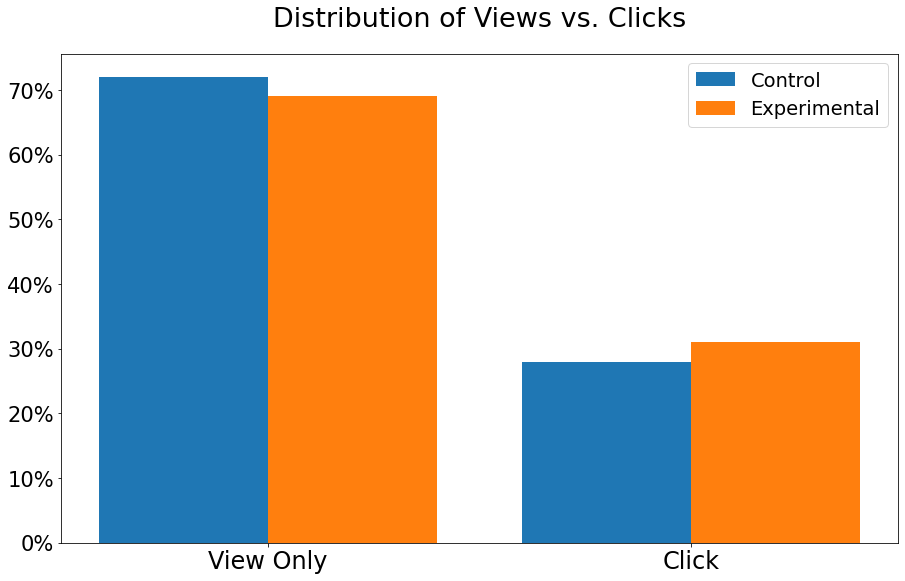

In [14]:
fig, ax = plt.subplots(figsize=(15, 9))

ax.hist(x=[control_clean.action, experimental_clean.action], label=['Control', 'Experimental'], 
        bins=[0,1,2], align='left', density=True)

ax.set_title('Distribution of Views vs. Clicks', size=27, pad=27)
ax.set_xticks([0, 1])
ax.set_xticklabels(['View Only', 'Click'], size=24)

def percentage_ticks(y, pos):
    return '{:.0f}%'.format(y*1e2)
    
ax.yaxis.set_major_formatter(percentage_ticks)
plt.setp(ax.get_yticklabels(), size=21)

ax.legend(prop={'size': 19.5});

In [15]:
H_null = 'The proportion of clicks did not increase significantly with the new homepage design.'
H_alt = 'The proportion of clicks did increase significantly with the new homepage design.'

print('H_o: ', H_null)
print()
print('H_a: ', H_alt)

H_o:  The proportion of clicks did not increase significantly with the new homepage design.

H_a:  The proportion of clicks did increase significantly with the new homepage design.


In [16]:
p_1 = p_value_welch_ttest(control_clean.action, experimental_clean.action)
p_1

0.004466402814336634

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [17]:
control_click_rate = control_clean.action.mean()
n_exp = len(experimental_clean)
expect_mean = n_exp * control_click_rate
print(expect_mean)

838.0168067226891


### Step 2:
Calculate the number of standard deviations <span style='color: red'><strong>&bigotimes;( z-score )&bigotimes;</strong></span> that the actual number of clicks was from this estimate.

In [18]:
var = n_exp * control_click_rate * (1 - control_click_rate)
std = np.sqrt(var)
std

24.568547907005815

In [19]:
z = (experimental_clean.action.sum() - expect_mean) / std 
z

3.6625360854823588

### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [20]:
p_2 = stats.norm.sf(z)
p_2

0.00012486528006951198

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: The second p-value is lower but they are both very small, and would lead to a rejection of the null hypothesis even at <strong>&#945;</strong> = .01.  The new homepage design does seem to be a better design.

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.